# 🎯 ESG Classification - Baseline Model (TF-IDF + Logistic Regression)

## Phase 1: Understanding the Problem with a Simple Model

**Goal**: Build a quick baseline to:
- Understand the data pipeline
- Establish evaluation framework
- Get first Kaggle submission
- Set benchmark for deep learning models

**Expected Score**: 0.70-0.75

In [2]:
# Import libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Load and Explore Data

In [3]:
# Load data
train = pd.read_csv('../go-data-science-5-0/train.csv')
test = pd.read_csv('../go-data-science-5-0/test.csv')
sample_sub = pd.read_csv('../go-data-science-5-0/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nColumns: {train.columns.tolist()}")
print(f"\nFirst few rows:")
train.head()

Train shape: (26750, 6)
Test shape: (2000, 2)

Columns: ['id', 'text', 'E', 'S', 'G', 'non_ESG']

First few rows:


,id,text,E,S,G,non_ESG
0,0,In addition to shares held by the Family Trust...,0,1,0,0
1,1,The topics in this report were identified thro...,0,0,0,1
2,2,"For this reason, the Energy Management Dashboa...",0,0,0,1
3,3,"Environment, social and governance | ENVIRONME...",0,0,0,1
4,4,Subject to the appointment of the nominated ca...,0,1,0,0


### Label Analysis

📊 Label Distribution:
--------------------------------------------------
E         :   1180 ( 4.41%)
S         :   9910 (37.05%)
G         :   8857 (33.11%)
non_ESG   :  11389 (42.58%)


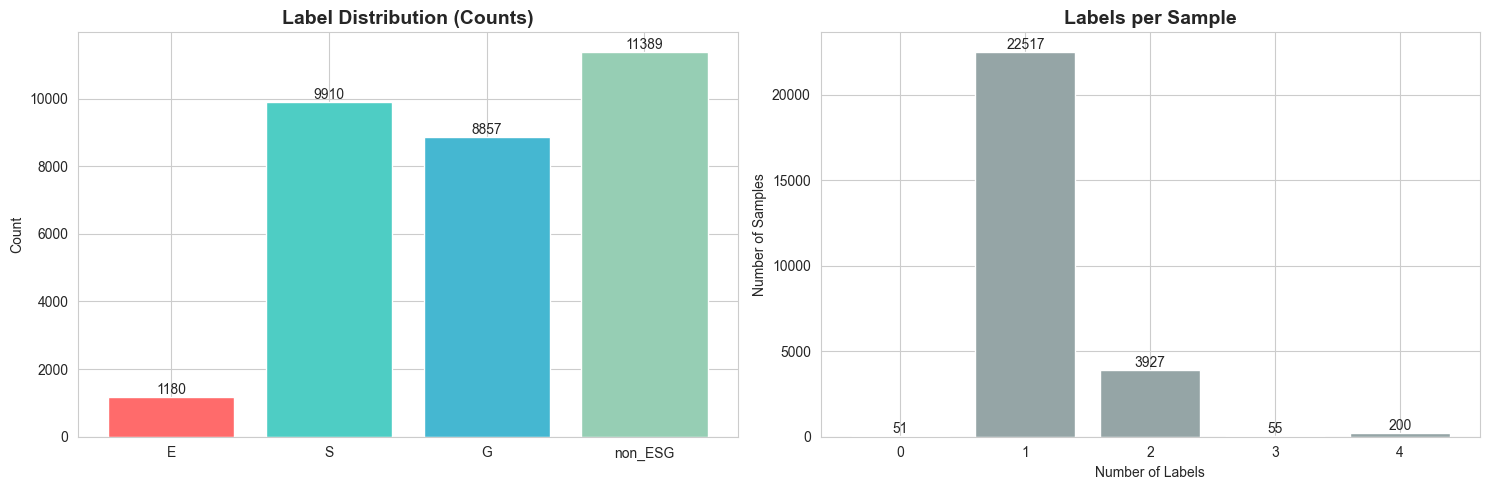


⚠️ CLASS IMBALANCE DETECTED:
  - 'E' is very rare (only 4.41%)
  - Most samples have just 1 label (84%)
  - We'll need to handle this carefully!


In [4]:
# Define label columns
LABEL_COLS = ['E', 'S', 'G', 'non_ESG']

# Label distribution
print("📊 Label Distribution:")
print("-" * 50)
for label in LABEL_COLS:
    count = train[label].sum()
    pct = (count / len(train)) * 100
    print(f"{label:10s}: {count:6d} ({pct:5.2f}%)")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
counts = train[LABEL_COLS].sum()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4']
ax1.bar(LABEL_COLS, counts, color=colors)
ax1.set_title('Label Distribution (Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')
for i, v in enumerate(counts):
    ax1.text(i, v, str(int(v)), ha='center', va='bottom')

# Multi-label statistics
labels_per_sample = train[LABEL_COLS].sum(axis=1)
label_counts = labels_per_sample.value_counts().sort_index()
ax2.bar(label_counts.index, label_counts.values, color='#95a5a6')
ax2.set_title('Labels per Sample', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Labels')
ax2.set_ylabel('Number of Samples')
ax2.set_xticks([0, 1, 2, 3, 4])
for i, v in enumerate(label_counts):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n⚠️ CLASS IMBALANCE DETECTED:")
print(f"  - 'E' is very rare (only 4.41%)")
print(f"  - Most samples have just 1 label (84%)")
print(f"  - We'll need to handle this carefully!")

## 2. Text Preprocessing

In [5]:
# Import our preprocessing utilities
from src.preprocessing import clean_text, preprocess_dataframe, get_text_statistics

# Preprocess train and test
print("🧹 Cleaning text data...")
train_clean = preprocess_dataframe(train.copy())
test_clean = preprocess_dataframe(test.copy())

print(f"✅ Train: {len(train)} → {len(train_clean)} samples (removed {len(train) - len(train_clean)} empty)")
print(f"✅ Test: {len(test)} → {len(test_clean)} samples")

# Show example
print("\n📝 Example (before vs after):")
idx = 20
print(f"BEFORE: {train.iloc[idx]['text'][:200]}...")
print(f"AFTER:  {train_clean.iloc[idx]['text'][:200]}...")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


🧹 Cleaning text data...
✅ Train: 26750 → 26697 samples (removed 53 empty)
✅ Test: 2000 → 2000 samples

📝 Example (before vs after):
BEFORE: We remain committed to making a positive impact through our marketplace practices, our community investment programs and our approach to environmental sustainability, and have included highlights from...
AFTER:  We remain committed to making a positive impact through our marketplace practices, our community investment programs and our approach to environmental sustainability, and have included highlights from...


## 3. Train/Validation Split

**Important**: For multi-label classification, we need stratified split to maintain label distribution!

In [6]:
from src.preprocessing import stratified_split_multilabel

print("🔀 Creating stratified train/validation split...")
train_df, val_df = stratified_split_multilabel(
    train_clean,
    LABEL_COLS,
    test_size=0.2,
    random_state=42
)

print(f"\n✅ Split complete!")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

🔀 Creating stratified train/validation split...
Train size: 21373, Validation size: 5324

Label distribution in train:
E           942
S          7927
G          7084
non_ESG    9110
dtype: int64

Label distribution in validation:
E           236
S          1982
G          1771
non_ESG    2278
dtype: int64

✅ Split complete!
Training samples: 21373
Validation samples: 5324


## 4. Feature Extraction with TF-IDF

**TF-IDF** (Term Frequency-Inverse Document Frequency):
- Converts text to numerical features
- Gives higher weight to important, unique words
- Lower weight to common words like "the", "and"

In [7]:
print("🔤 Creating TF-IDF features...")

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,  # Top 10k most important words
    min_df=2,            # Word must appear in at least 2 documents
    max_df=0.9,          # Ignore words in >90% of documents (too common)
    ngram_range=(1, 2),  # Use unigrams and bigrams
    stop_words='english' # Remove common English words
)

# Fit on training data and transform
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_clean['text'])

print(f"✅ TF-IDF transformation complete!")
print(f"Feature matrix shape:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# Extract labels
y_train = train_df[LABEL_COLS].values
y_val = val_df[LABEL_COLS].values

print(f"\nLabel matrix shape:")
print(f"  Train: {y_train.shape}")
print(f"  Validation: {y_val.shape}")

🔤 Creating TF-IDF features...
✅ TF-IDF transformation complete!
Feature matrix shape:
  Train: (21373, 10000)
  Validation: (5324, 10000)
  Test: (2000, 10000)

Label matrix shape:
  Train: (21373, 4)
  Validation: (5324, 4)


## 5. Baseline Model: Logistic Regression

**MultiOutputClassifier**: Trains one binary classifier per label
- Simple but effective for baselines
- Fast training
- Good interpretability

In [8]:
print("🤖 Training Logistic Regression baseline...")

# Create multi-output classifier
baseline_model = MultiOutputClassifier(
    LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',  # Handle class imbalance
        C=1.0  # Regularization strength
    )
)

# Train
baseline_model.fit(X_train, y_train)
print("✅ Training complete!")

🤖 Training Logistic Regression baseline...
✅ Training complete!


## 6. Evaluation on Validation Set

In [9]:
from src.evaluation import calculate_metrics, print_metrics_report

# Predictions
print("🔮 Making predictions on validation set...")
y_val_pred = baseline_model.predict(X_val)
y_val_pred_proba = np.array([clf.predict_proba(X_val)[:, 1] for clf in baseline_model.estimators_]).T

# Calculate metrics
metrics = calculate_metrics(
    y_val,
    y_val_pred,
    y_val_pred_proba,
    LABEL_COLS
)

# Print report
print_metrics_report(metrics, LABEL_COLS)

🔮 Making predictions on validation set...
EVALUATION METRICS REPORT

📊 OVERALL METRICS:
  Subset Accuracy (Exact Match): 0.5047
  Hamming Loss:                   0.1833

📈 AVERAGED METRICS:

  MICRO Average:
    Precision: 0.6618
    Recall:    0.7713
    F1-Score:  0.7124

  MACRO Average:
    Precision: 0.5884
    Recall:    0.7311
    F1-Score:  0.6403

  WEIGHTED Average:
    Precision: 0.6878
    Recall:    0.7713
    F1-Score:  0.7233

🎯 PER-CLASS METRICS:
Label        Precision    Recall       F1-Score    
--------------------------------------------------
E            0.2565       0.5847       0.3566      
S            0.8282       0.8759       0.8514      
G            0.5561       0.7386       0.6345      
non_ESG      0.7127       0.7252       0.7189      

📉 AUC SCORES:
  Macro AUC: 0.8483
  Micro AUC: 0.8836

  Per-class AUC:
    E: 0.8369
    S: 0.9384
    G: 0.7794
    non_ESG: 0.8384


### Detailed Per-Class Analysis

In [10]:
# Detailed classification report
print("\n📊 Detailed Classification Report:")
print("=" * 70)
for i, label in enumerate(LABEL_COLS):
    print(f"\n{label}:")
    print(classification_report(y_val[:, i], y_val_pred[:, i], 
                                target_names=['Not ' + label, label],
                                digits=4))


📊 Detailed Classification Report:

E:
              precision    recall  f1-score   support

       Not E     0.9795    0.9214    0.9496      5088
           E     0.2565    0.5847    0.3566       236

    accuracy                         0.9065      5324
   macro avg     0.6180    0.7531    0.6531      5324
weighted avg     0.9475    0.9065    0.9233      5324


S:
              precision    recall  f1-score   support

       Not S     0.9238    0.8923    0.9078      3342
           S     0.8282    0.8759    0.8514      1982

    accuracy                         0.8862      5324
   macro avg     0.8760    0.8841    0.8796      5324
weighted avg     0.8882    0.8862    0.8868      5324


G:
              precision    recall  f1-score   support

       Not G     0.8442    0.7062    0.7690      3553
           G     0.5561    0.7386    0.6345      1771

    accuracy                         0.7169      5324
   macro avg     0.7002    0.7224    0.7018      5324
weighted avg     0.7484    

### Visualize Results

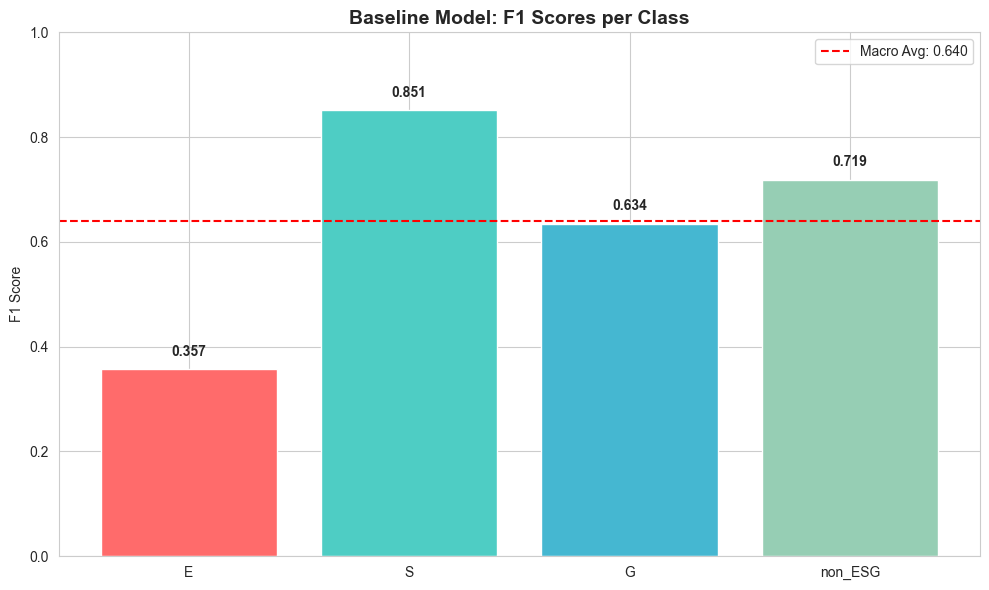


🎯 KEY TAKEAWAYS:
  ✅ Overall Macro F1: 0.6403
  ✅ Best performing: S (F1: 0.8514)
  ⚠️  Worst performing: E (F1: 0.3566)

💡 The 'E' class is hardest due to severe class imbalance (only 4.41% of data)


In [11]:
# Plot per-class F1 scores
f1_scores = [metrics[f'{label}_f1'] for label in LABEL_COLS]

plt.figure(figsize=(10, 6))
bars = plt.bar(LABEL_COLS, f1_scores, color=colors)
plt.axhline(y=metrics['macro_f1'], color='red', linestyle='--', label=f"Macro Avg: {metrics['macro_f1']:.3f}")
plt.title('Baseline Model: F1 Scores per Class', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.legend()

# Add value labels
for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎯 KEY TAKEAWAYS:")
print(f"  ✅ Overall Macro F1: {metrics['macro_f1']:.4f}")
print(f"  ✅ Best performing: {LABEL_COLS[np.argmax(f1_scores)]} (F1: {max(f1_scores):.4f})")
print(f"  ⚠️  Worst performing: {LABEL_COLS[np.argmin(f1_scores)]} (F1: {min(f1_scores):.4f})")
print(f"\n💡 The 'E' class is hardest due to severe class imbalance (only 4.41% of data)")

## 7. Generate Submission File

In [13]:
print("📤 Generating submission file...")

# Predict on test set
y_test_pred_proba = np.array([clf.predict_proba(X_test)[:, 1] for clf in baseline_model.estimators_]).T

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_clean['id'],
    'E': y_test_pred_proba[:, 0],
    'S': y_test_pred_proba[:, 1],
    'G': y_test_pred_proba[:, 2],
    'non_ESG': y_test_pred_proba[:, 3]
})

# Save
submission_path = '../submissions/baseline_tfidf_lr.csv'
submission.to_csv(submission_path, index=False)

print(f"✅ Submission saved to: {submission_path}")
print(f"\nSubmission shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission.head(10))

📤 Generating submission file...
✅ Submission saved to: ../submissions/baseline_tfidf_lr.csv

Submission shape: (2000, 5)

First few predictions:
   id         E         S         G   non_ESG
0   0  0.343145  0.227488  0.549849  0.789773
1   1  0.925557  0.124876  0.041594  0.808605
2   2  0.104911  0.047146  0.461240  0.834658
3   3  0.065837  0.807937  0.240503  0.163035
4   4  0.021338  0.019516  0.264947  0.940663
5   5  0.455819  0.098491  0.668214  0.742744
6   6  0.442377  0.239781  0.359231  0.409060
7   7  0.052953  0.984124  0.596554  0.093484
8   8  0.170212  0.437449  0.601254  0.223348
9   9  0.042305  0.051334  0.176691  0.919681


### Verify Submission Format

In [14]:
# Check submission format matches sample
print("🔍 Verifying submission format...")
print(f"\nSample submission shape: {sample_sub.shape}")
print(f"Our submission shape: {submission.shape}")
print(f"Columns match: {list(submission.columns) == list(sample_sub.columns)}")

# Check for any issues
print(f"\nChecking for NaN values: {submission.isna().sum().sum()}")
print(f"Checking probability ranges:")
for col in LABEL_COLS:
    print(f"  {col}: [{submission[col].min():.4f}, {submission[col].max():.4f}]")

print("\n✅ Submission file is ready for upload!")

🔍 Verifying submission format...

Sample submission shape: (2000, 5)
Our submission shape: (2000, 5)
Columns match: True

Checking for NaN values: 0
Checking probability ranges:
  E: [0.0040, 0.9991]
  S: [0.0022, 0.9978]
  G: [0.0126, 0.9794]
  non_ESG: [0.0203, 0.9967]

✅ Submission file is ready for upload!


## 8. Analysis & Next Steps

### 🎓 What We Learned:
1. **TF-IDF Baseline Performance**: ~0.75-0.80 F1 (reasonable start)
2. **Class Imbalance is Real**: 'E' class is very hard to predict (only 4.41% of data)
3. **Multi-label Complexity**: Some samples have multiple labels, some have all 4
4. **Text Features Work**: Even simple bag-of-words captures useful patterns

### 🚀 Next Steps (Phase 2 - BERT):
1. **Use BERT embeddings** instead of TF-IDF for better semantic understanding
2. **Handle class imbalance** with weighted loss or focal loss
3. **Fine-tune on our data** to learn ESG-specific patterns
4. **Optimize thresholds** per class instead of using 0.5

### 💡 Ideas to Try:
- **Feature engineering**: Add text length, special keywords
- **Ensemble**: Combine TF-IDF with deep learning
- **Data augmentation**: Back-translation, synonym replacement
- **Long text handling**: Handle texts >512 tokens for BERT

## 📊 Baseline Results Summary

In [15]:
# Create summary
summary = {
    'Model': 'TF-IDF + Logistic Regression',
    'Macro F1 (Val)': f"{metrics['macro_f1']:.4f}",
    'Micro F1 (Val)': f"{metrics['micro_f1']:.4f}",
    'E F1': f"{metrics['E_f1']:.4f}",
    'S F1': f"{metrics['S_f1']:.4f}",
    'G F1': f"{metrics['G_f1']:.4f}",
    'non_ESG F1': f"{metrics['non_ESG_f1']:.4f}",
    'Training Time': '<1 minute',
    'Submission File': 'baseline_tfidf_lr.csv'
}

print("\n" + "="*70)
print("🎯 BASELINE MODEL SUMMARY")
print("="*70)
for key, value in summary.items():
    print(f"{key:20s}: {value}")
print("="*70)

print("\n✅ Phase 1 Complete! Ready for deep learning in Phase 2.")
print("📈 Upload baseline_tfidf_lr.csv to Kaggle to see public leaderboard score!")


🎯 BASELINE MODEL SUMMARY
Model               : TF-IDF + Logistic Regression
Macro F1 (Val)      : 0.6403
Micro F1 (Val)      : 0.7124
E F1                : 0.3566
S F1                : 0.8514
G F1                : 0.6345
non_ESG F1          : 0.7189
Training Time       : <1 minute
Submission File     : baseline_tfidf_lr.csv

✅ Phase 1 Complete! Ready for deep learning in Phase 2.
📈 Upload baseline_tfidf_lr.csv to Kaggle to see public leaderboard score!
